In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import pathlib
from torch import Tensor

from comics_net.URLs import URLs

In [3]:
url = URLs.justice_league
path = download_data(url)
dest = url2path(url, True)
tf = tarfile.open(path, 'r:gz').extractall(dest.parent)

In [4]:
path = pathlib.Path(dest)
path.ls()

[PosixPath('/Users/smacrae/.fastai/data/justice_league/images'),
 PosixPath('/Users/smacrae/.fastai/data/justice_league/labels.txt')]

In [5]:
path_img = path/'images'
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/Users/smacrae/.fastai/data/justice_league/images/Robin: Robin #117 Direct Sales (2003-08-20).jpg'),
 PosixPath('/Users/smacrae/.fastai/data/justice_league/images/The Flash: The Flash #105 Original (1958-12-23).jpg'),
 PosixPath('/Users/smacrae/.fastai/data/justice_league/images/Batman: Batman #659 Direct Sales (2006-11-29).jpg'),
 PosixPath('/Users/smacrae/.fastai/data/justice_league/images/Detective Comics: Detective Comics #455 Original (1975-10-28).jpg'),
 PosixPath('/Users/smacrae/.fastai/data/justice_league/images/The Flash: The Flash #46 Looney Tunes Variant Cover (2015-11-25).jpg')]

In [6]:
bs = 32

base_ratio = 200
"{} x {}".format(base_ratio * (600 / 400), base_ratio)

'300.0 x 200'

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

from fastai.vision.transform import RandTransform

rand_rotate = rotate(degrees=(-15, 15), p=0.5)
rand_flip = rotate(degrees=(180), p=0.5)
rand_flip_lr = flip_lr(p=0.5)
rand_zoom = zoom(scale=1.1, p=0.5)

data = ImageDataBunch.from_csv(path=path, 
                               folder="images",
                               csv_labels="labels.txt",
                               fn_col=0,
                               label_col=1,
                               delimiter="\t",
                               label_delim="|",
                               valid_pct=0.2,
                               size=(300, 200),
                               ds_tfms=([rand_rotate, rand_flip, rand_flip_lr, rand_zoom], []))

data

ImageDataBunch;

Train: LabelList (9126 items)
x: ImageList
Image (3, 300, 200),Image (3, 300, 200),Image (3, 300, 200),Image (3, 300, 200),Image (3, 300, 200)
y: MultiCategoryList
Aquaman Arthur Curry,Batman Bruce Wayne,Green Lantern Hal Jordan,Wonder Woman Diana Prince,Catwoman Selina Kyle
Path: /Users/smacrae/.fastai/data/justice_league;

Valid: LabelList (2281 items)
x: ImageList
Image (3, 300, 200),Image (3, 300, 200),Image (3, 300, 200),Image (3, 300, 200),Image (3, 300, 200)
y: MultiCategoryList
Batman Bruce Wayne,Batman Bruce Wayne,Wonder Woman Diana Prince;Flash Barry Allen;Martian Manhunter Jonn Jonzz;Green Lantern Hal Jordan;Green Arrow Oliver Queen,Green Lantern Hal Jordan,Aquaman Arthur Curry
Path: /Users/smacrae/.fastai/data/justice_league;

Test: None

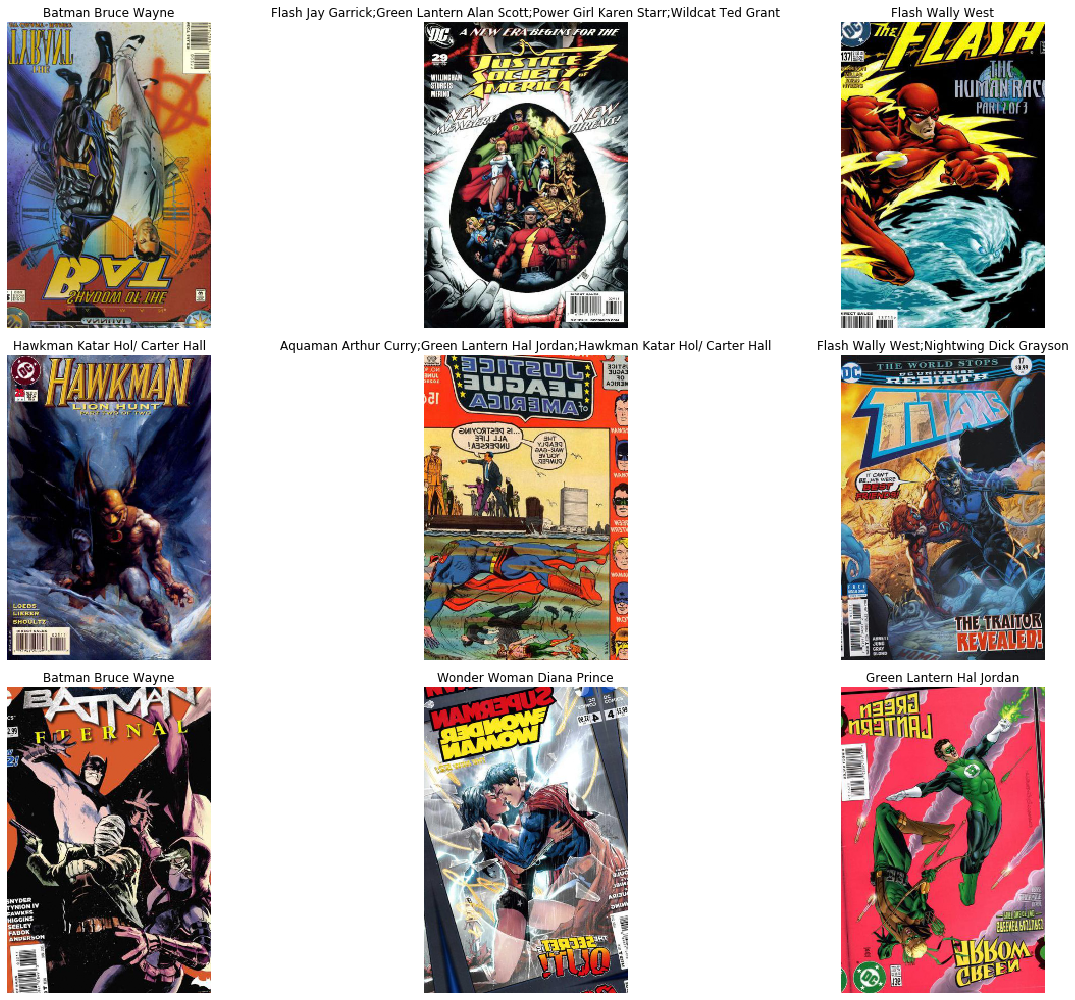

In [9]:
data.show_batch(rows=3, figsize=(16, 14))

In [10]:
print(data.classes)
len(data.classes), data.c

['Aquaman Arthur Curry', 'Atom Ray Palmer', 'Batman Bruce Wayne', 'Beast Boy Gar Logan', 'Black Canary Dinah Laurel Lance', 'Black Lightning Jefferson Pierce', 'Catwoman Selina Kyle', 'Changeling Garfield Logan', 'Cyborg Victor Stone', 'Elongated Man Ralph Dibny', 'Flash Barry Allen', 'Flash Jay Garrick', 'Flash Wally West', 'Green Arrow Oliver Queen', 'Green Lantern Alan Scott', 'Green Lantern Hal Jordan', 'Green Lantern Kyle Rayner', 'Hawkgirl Shayera Thal', 'Hawkman Katar Hol/ Carter Hall', 'Huntress Helena Bertinelli', 'Katana Tatsu Yamashiro', 'Kid Flash Wally West', 'Martian Manhunter Jonn Jonzz', 'Nightwing Dick Grayson', 'Power Girl Karen Starr', 'Raven Rachel Roth', 'Red Robin Tim Drake', 'Robin Dick Grayson', 'Speedy Roy Harper', 'Starfire Koriandr', 'Wildcat Ted Grant', 'Wonder Girl Cassie Sandsmark', 'Wonder Girl Donna Troy', 'Wonder Woman Diana Prince', 'Zatanna Zatanna Zatara']


(35, 35)

Deep Learning Experiments

1. Resnet 34 (train a comic book specific resnet model)
2. Language Model (create a language model that writes comic book synopses)
3. Style Transfer (create style filters and apply them to covers)
4. Character / Object Detection (detect characters on a cover)
5. GAN ("dream" comic book covers)
6. Joint Probability Synopsis/Cover (given a synopsis, generate a comic book cover)

In [11]:
arch = models.resnet50
# arch = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


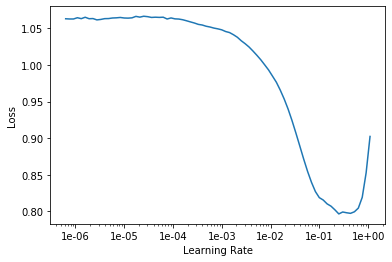

In [14]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


In [ ]:
learn.save("justice-league-stage-1-rn50-unfreeze")

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, slice(1e-3, lr/5))

In [ ]:
learn.save("avengers-stage-2-rn34-unfreeze")

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# # test loading model architecture and weights
# arch = models.resnet50
# learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
# learn.load("avengers-stage-2-rn50")

In [ ]:
learn.show_results(rows=3, figsize=(16, 14))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from inspect import signature

def pr_curve(c: str):
    # this is just copied from sklearn docs
    i = data.classes.index(c)
    y_true, y_scores = labeled_preds[i][:, 0], labeled_preds[i][:, 1]
    return precision_recall_curve(y_true, y_scores)

def plot_pr_curve(c: str, y_true: array, y_score: array):
    # this is just copied from sklearn docs
    precision, recall, threshold = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

def threshold_at_prec(precision: array, threshold: array,  prec: float):
    return interp1d(precision, threshold, kind="linear")([prec])[0]

In [ ]:
# threshold[np.argmax(precision[:-1])]

In [ ]:
# get learner scores (preds) and labels (targets)
val_preds, val_targets = learn.get_preds()

### Investigate Multi-label Confusion

In [ ]:
# set_diffs = {}

# for i in range(torch.stack(y_trues).shape[1]):
#     set_diffs[i] = {}
    
#     set_diffs[i]["labels"] = set([c for c, n in zip(data.classes, torch.stack(y_trues)[:, i]) if n == 1])
    
#     set_diffs[i]["missed"] = set([c for c, n in zip(data.classes, torch.stack(y_trues)[:, i]) if n == 1]).difference(
#         set([c for c, n in zip(data.classes, torch.stack(y_preds)[:, i]) if n == 1]))

#     set_diffs[i]["incorrect"] = set([c for c, n in zip(data.classes, torch.stack(y_preds)[:, i]) if n == 1]).difference(
#         set([c for c, n in zip(data.classes, torch.stack(y_trues)[:, i]) if n == 1]))

#     set_diffs[i]["correct"] = set([c for c, n in zip(data.classes, torch.stack(y_preds)[:, i]) if n == 1]).intersection(
#         set([c for c, n in zip(data.classes, torch.stack(y_trues)[:, i]) if n == 1]))

In [ ]:
# classifications = pd.DataFrame(set_diffs).T

# classifications["perfect"] = pd.Series(
#     pd.Series([x == set() for x in classifications["incorrect"]]) & 
#     pd.Series([x == set() for x in classifications["missed"]])
# ).astype(int)

# classifications["confused"] = pd.Series(
#     pd.Series([x != set() for x in classifications["incorrect"]]) & 
#     pd.Series([x != set() for x in classifications["missed"]])
# ).astype(int)

# classifications["none"] = pd.Series(
#     pd.Series([x == set() for x in classifications["correct"]])
# ).astype(int)

# # re-order columns for readability
# classifications = classifications[["labels", "correct", "incorrect", "missed", "perfect", "confused", "none"]]

# classifications.head()

In [ ]:
# # consider labels x incorrect as one confusion
# # consider missed x correct as another confusion

# # in the first case we have some set of actual labels we'd like to predict, but we may predict some set of labels not actually present.
# #  this is confusion between what's actually there and  what we  predicted was there, for example:

# # in the first case, assume the actual labels are {Veronica Lodge, Betty Cooper, Archie Andrews} and we incorrectly predict {Reggie Mantle, Jughead Jones}.
# # there is clear confusion between these 5 labels but we can't (at this level of analysis) infer if there is any confusion between a specific
# # label and some other specific label. So the fact that there is confusion amongst this group can at best  be  represented in a confusion matrix
# # using a cartesian product of sets, or, Reggie Mantle is confused with Veronica Lodge, Betty Cooper and Archie Andrews (and we update those 3 cells
# # in our confusion matrix), and Jughead Jones is also confused with Veronica Lodge, Betty Cooper and Archie Andrews (and we update those 3 cells too).

# # in the second case, assume the actual labels are {Betty Cooper, Archie Andrews, Jughead Jones} and we correctly predict {Jughead Jones}, but we miss 
# # {Betty Cooper, Archie Andrews}. There is clear confusion between these 3 labels but we can't infer any confusion between specific labels. So we
# # represent this confusion using a cartesian product of sets, or, Betty Cooper is confused with with Jughead Jones and Archie Andrews is also confused
# # with Jughead Jones (and each of those cells gets updated in our confusion matrix).

# # we can have instances where both cases occur and we simultaneously make incorrect predictions and miss actual labels, and in that case we just
# # apply each case indepently to the confusion matrix and potentially update  a large number of cells, depending on the size of the cartesian products.

# # the hope is that, with enough observations we will be able to identify specific label to label confusion (if it exists) because if there is 
# # correlation between one class and another class being confused,  but it occurs within the context of some other confusions at times, with
# # enough observations it should have a larger relative frequency in our confusion matrix. Because the counts in the confusion matrix do not
# # represent the

# t  = classifications.sample()
# t

In [ ]:
# def incorrect_and_missed(t):
#     d = dict()
#     for missed in t["missed"].iloc[0]:
#         for incorrect in t["incorrect"].iloc[0]:
#             d.update({missed: incorrect})
#     return d
        
# def just_incorrect(t):
#     d = dict()
#     for incorrect in t["incorrect"].iloc[0]:
#         for label in t["labels"].iloc[0]:
#             d.update({incorrect: label})
#     return d

In [ ]:
# d = incorrect_and_missed(t)
# d.update(just_incorrect(t))
# d

### Investigate Multi-label Classification Accuracy

In [ ]:
# val_preds, val_targets = learn.get_preds()
val_preds, val_targets

In [ ]:
#TODO: implement this...
# https://docs.fast.ai/train.html#ClassificationInterpretation
import warnings
from sklearn.metrics import confusion_matrix
# TODO: implement w/ multilabel confusion matrix
# from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import average_precision_score


class MultiLabelClassificationInterpretation(Interpretation):
    "Interpretation methods for classification models."
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid, prec:float=0.90):
        super().__init__(learn,preds,y_true,losses,ds_type)
        self.prec = prec
        self.my_threshold = self.get_threshold()
        self.my_confusion_matrix = self.confusion_matrix()
    
    def pr_curves(self):
        "Precision/recall curves by class as a `dict[np.ndarray]`."
        pr_curves = dict()
        for c in self.learn.data.classes:
            pr_curves[c] = {}
            idx = self.learn.data.classes.index(c)
            pr_curves[c]["precision"], pr_curves[c]["recall"], pr_curves[c]["threshold"] = precision_recall_curve(self.y_true[:, idx], self.preds[:, idx])
        return pr_curves
    
    def get_threshold(self):
        "Model scores at some precision by class as a `dict[float]`."
        ths = {}
        for c in self.learn.data.classes:
            ths[c] = {}
            try:
                threshold = interp1d(self.pr_curves()[c]["precision"][:-1], self.pr_curves()[c]["threshold"], kind="linear")([self.prec])[0]
                ths[c]["prediction_threshold"] = threshold
            except:
                # if 90% precision does not exist, return threshold at max precision
                best_prec = max(self.pr_curves()[c]["precision"][:-1])
                ths[c]["prediction_threshold"] = self.pr_curves()[c]["threshold"][np.argmax(self.pr_curves()[c]["precision"][:-1])]
                warnings.warn("Warning: Best precision available for {} is {}".format(c, best_prec))
        return ths

            
    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`."
        cm = dict()
        for c in self.learn.data.classes:
            cm[c] = {}
            idx = self.learn.data.classes.index(c)
            y_pred = self.preds[:, idx] >= self.my_threshold[c]["prediction_threshold"]
            cm[c]["cm"] = confusion_matrix(self.y_true[:, idx], y_pred)
            cm[c]["avg_prec"] = average_precision_score(self.y_true[:, idx], y_pred)
        return cm
    
    def plot_confusion_matrix(self, normalize:bool=False, cmap:Any="Blues", slice_size:int=1,
                              norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs)->Optional[plt.Figure]:
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.my_confusion_matrix
        for c in self.learn.data.classes:
            cm = self.my_confusion_matrix[c]["cm"]
            avg_prec = self.my_confusion_matrix[c]["avg_prec"]
            if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fig = plt.figure(**kwargs)
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title('Confusion matrix \n {0}  (Avg Precision = {1:1.2f})'.format(c, avg_prec))

            if plot_txt:
                thresh = cm.max() / 2.
                for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                    coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                    plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

            ax = fig.gca()

            plt.tight_layout()
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.grid(False)
            if ifnone(return_fig, defaults.return_fig): return fig
            
    
    def most_confused(self, min_val:int=1, slice_size:int=1)->Collection[Tuple[str,str,int]]:
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        return False

In [ ]:
# %%timeit

MultiLabelClassificationInterpretation(learn, val_preds, val_targets, Tensor(), prec=0.90).plot_confusion_matrix()

In [ ]:
# refer to the binary class to implement multilabel above...

class ClassificationInterpretation(Interpretation):
    "Interpretation methods for classification models."
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        super().__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.argmax(dim=1)

    def confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            for i in range(0, self.y_true.shape[0], slice_size):
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size]==x[:,None,None])).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", slice_size:int=1,
                              norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs)->Optional[plt.Figure]:
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix(slice_size=slice_size)
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(self.data.c)
        plt.xticks(tick_marks, self.data.y.classes, rotation=90)
        plt.yticks(tick_marks, self.data.y.classes, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        ax = fig.gca()
        ax.set_ylim(len(self.data.y.classes)-.5,-.5)
                           
        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)
        if ifnone(return_fig, defaults.return_fig): return fig

    def most_confused(self, min_val:int=1, slice_size:int=1)->Collection[Tuple[str,str,int]]:
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        cm = self.confusion_matrix(slice_size=slice_size)
        np.fill_diagonal(cm, 0)
        res = [(self.data.classes[i],self.data.classes[j],cm[i,j])
                for i,j in zip(*np.where(cm>=min_val))]
        return sorted(res, key=itemgetter(2), reverse=True)

### Visualize Layers of the CNN